### Imports


In [271]:
# Imports and settings

from collections import defaultdict

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from IPython.display import Latex, display
from matplotlib.axes import Axes
from matplotlib.backends.backend_pdf import PdfPages
from matplotlib.legend_handler import HandlerBase, HandlerTuple
from matplotlib.lines import Line2D

from graph_expansion import *


plt.rc(
    "text.latex",
    preamble=r"""
\usepackage{amsfonts}
\usepackage{amsmath}
\usepackage{mathtools}
\newcommand{\avg}[1]{\mathopen{}\left\langle #1 \right\rangle\mathclose{}}
\newcommand{\p}[1]{\mathopen{}\left\lparen #1 \right\rparen\mathclose{}}
\newcommand{\conj}[1]{\overline{#1}}
\newcommand{\G}{\widetilde{G}}
\newcommand{\m}{\mathbf{m}}
\newcommand{\E}{\mathbb{E}}
""",
)

## Leading Terms of $\E\avg{\prod_{i=1}^n G\p{\sigma_i}E_{a_i}}$


### Main Script

In [272]:
# Helper functions

from math import floor


def size2(x: Graph):
    n_sums = len(
        [f for t in x.traces for f in t if isinstance(f, E) and isinstance(f.i, b)]
    )
    px, qx = p(x), q(x)
    loops = sum([floor(3 * k(t) / 2) - 2 for t in x.g_loops])

    return Size(
        -(px + qx),
        -(qx + loops)
        - len(
            [
                c
                for c in x.coefficients
                if isinstance(c, Theta | STheta) and c.charges[0] != c.charges[1]
            ]
        ),
    )

In [273]:
# Expand to order 1/N

initial_loop = Trace(
    G(),
    E(a(1)),
    adjoint(G()),
    E(a(2)),
    G(),
    E(a(3)),
    adjoint(G()),
    E(a(4)),
    G(),
    E(a(5)),
    adjoint(G()),
    E(a(6)),
    G(),
    E(a(7)),
    adjoint(G()),
    E(a(8)),
)

x0 = Graph(initial_loop)
stack: list[Graph] = [x0]
pre_leading_terms: list[Graph] = []
small_terms: list[Graph] = []
n_expansions = 0
expansion_depths = {}

while stack:
    x = stack.pop()

    # Stop if the graph is deterministic
    if x.is_deterministic():
        pre_leading_terms.append(x)
        continue

    # Stop if the graph is small enough
    # if (size2(x) / size2(x0)).n_exponent <= -1:
    if q(x) > 0:
        small_terms.append(x)
        continue

    n_expansions += 1
    # if x.light_weights:
    #     stack.extend([Graph(x1, expansions + 1) for x1 in expand_light_weight(x)])
    if x.g_loops:
        stack.extend([x1 for x1 in expand_G_loop(x, trace_index=0)])


render(x0)
print("# deterministic graphs: ", len(pre_leading_terms))
print("# smaller graphs:       ", len(small_terms))
print("# expansions:           ", n_expansions)

<IPython.core.display.Latex object>

# deterministic graphs:  13594
# smaller graphs:        84249
# expansions:            25183


### Analysis of Leading Terms


In [274]:
# Rewrite graphs into more canonical forms

leading_terms: list[Graph] = []
for x in pre_leading_terms:
    old_coefficients = x.coefficients
    old_traces = x.traces

    # Perform some simple matrix multiplication
    # - \MS, S\Theta, S\Theta\MS, etc.
    coefficients: list[Coefficient] = []
    coefficients_to_remove_first_pass: list[int] = []
    removed_indices: set[Symbol] = set()

    # First pass to handle \Theta's
    coefficients_first_pass: list[Coefficient] = []
    for i, c in enumerate(old_coefficients):
        if i in coefficients_to_remove_first_pass:
            continue
        if isinstance(c, Theta) and isinstance(c.i, b) and isinstance(c.j, b):
            for j, c1 in enumerate(old_coefficients):
                if j in coefficients_to_remove_first_pass:
                    continue
                if isinstance(c1, S) and c1.j == c.i:
                    coefficients_to_remove_first_pass.extend([i, j])
                    coefficients_first_pass.append(
                        STheta(c.charges[0], c.charges[1], c1.i, c.j)
                    )
    coefficients_first_pass += [
        c
        for i, c in enumerate(old_coefficients)
        if i not in coefficients_to_remove_first_pass
    ]

    coefficients: list[Coefficient] = []
    coefficients_to_remove: list[int] = []
    for i, c in enumerate(coefficients_first_pass):
        if i in coefficients_to_remove:
            continue
        # Handle \M's
        if isinstance(c, calM) and isinstance(c.i, b) and isinstance(c.j, b):
            for j, c1 in enumerate(coefficients_first_pass):
                if j in coefficients_to_remove:
                    continue
                if isinstance(c1, S) and c1.j == c.i:
                    for k, c2 in enumerate(coefficients_first_pass):
                        if k in coefficients_to_remove:
                            continue
                        if (
                            isinstance(c2, Theta | STheta)
                            and c2.j == c.j
                            and c2.charges == (c.charges[1], c.charges[0])
                        ):
                            coefficients_to_remove.extend([i, j, k])
                            coefficients.append(
                                (ThetacalMS if isinstance(c2, Theta) else SThetacalMS)(
                                    c.charges[1], c.charges[0], c2.i, c1.i
                                )
                            )
                            removed_indices.union([c2.j, c.i, c.j])
    assert all([isinstance(i, b) for i in removed_indices])

    # Double-check that each b_i only appears at most twice
    for t in x.traces:
        for f in enumerate(t):
            if isinstance(f, E):
                assert f.i not in removed_indices

    for i, c in enumerate(coefficients_first_pass):
        if i in coefficients_to_remove:
            continue
        if isinstance(f, S | Theta | calM):
            assert f.i not in removed_indices and f.j not in removed_indices
    coefficients += [
        c for i, c in enumerate(coefficients_first_pass) if i not in coefficients_to_remove
    ]

    # Replace internal a_i's with delta_{a_ib_i}'s
    traces: list[Trace] = []
    traces_to_remove: list[int] = []
    next_b_index = largest_b_index(x) + 1
    for i, t in enumerate(old_traces):
        pre_trace: list[MatrixFactor] = []
        for f in t:
            if isinstance(f, E) and isinstance(f.i, a):
                coefficients.append(I(f.i, b(next_b_index)))
                pre_trace.append(E(b(next_b_index)))
                next_b_index += 1
            else:
                pre_trace.append(f)
        traces.append(Trace(pre_trace))

    leading_terms.append(Graph(coefficients, traces))

In [275]:
# Relabel graphs in a consistent way


class m(NumberedSymbol):
    def __init__(self, i: int):
        super().__init__("m", i)


type LeafPattern = tuple[tuple[int, tuple[Symbol, ...]], ...]


relabeled_leading_terms: list[Graph] = []

leaf_nodes = [f.i for f in initial_loop if isinstance(f, E)]
leaf_patterns: set[LeafPattern] = set()

# leading_term_loop_to_pattern[leading term][loop] -> LeafPattern
leading_term_loop_to_pattern: list[list[LeafPattern]] = []
for x in leading_terms:
    # Create a tree where each M-loop is viewed as a vertex
    quotient_map: dict[Symbol, m] = {}
    tree = nx.Graph()
    for i, t in enumerate(x.traces):
        tree.add_node(m(i))
        for f in t:
            if isinstance(f, E):
                quotient_map[f.i] = m(i)

    for c in x.coefficients:
        tree.add_edge(quotient_map.get(c.i, c.i), quotient_map.get(c.j, c.j))

    # Identify each M-loop with the depths of the leaf nodes when rooted at the M-loop
    loop_to_leaf_patterns: list[LeafPattern] = []
    for i, t in enumerate(x.traces):
        depths = defaultdict(list)
        for leaf_node in leaf_nodes:
            depths[nx.shortest_path_length(tree, m(i), leaf_node)].append(leaf_node)
        leaf_pattern: LeafPattern = tuple(
            sorted([(depth, tuple(layer)) for depth, layer in depths.items()])
        )

        loop_to_leaf_patterns.append(
            leaf_pattern
        )  # Used for indexing by leading term and loop index
        leaf_patterns.add(leaf_pattern)  # Used to number the loops
    leading_term_loop_to_pattern.append(loop_to_leaf_patterns)

# Finally update the indices
leaf_pattern_to_loop_number = {
    leaf_pattern: i + len(leaf_nodes) + 1
    for i, leaf_pattern in enumerate(leaf_patterns)
}
for x, loop_to_leaf_pattern in zip(leading_terms, leading_term_loop_to_pattern):
    # View the external indices as numbered loops also when updating indices
    index_to_loop_number: dict[Symbol, int] = {
        v: i + 1 for i, v in enumerate(leaf_nodes)
    }
    for i, (t, leaf_pattern) in enumerate(zip(x.traces, loop_to_leaf_pattern)):
        for f in t:
            if isinstance(f, E) and isinstance(f.i, b):
                index_to_loop_number[f.i] = leaf_pattern_to_loop_number[leaf_pattern]

    # Update the internal indices to d_{ij}, where i is the loop that d_{ij} is in and j is the loop it's connected to
    relabel_map: dict[Symbol, a | d] = {}
    coefficients: list[Coefficient] = []
    for c in x.coefficients:
        new_i = (
            d(index_to_loop_number[c.i], index_to_loop_number[c.j])
            if not isinstance(c.i, a)
            else c.i
        )
        new_j = (
            d(index_to_loop_number[c.j], index_to_loop_number[c.i])
            if not isinstance(c.j, a)
            else c.j
        )
        relabel_map[c.i] = new_i
        relabel_map[c.j] = new_j
        if isinstance(c, ChargedCoefficient):
            coefficients.append(c.__class__(c.charges[0], c.charges[1], new_i, new_j))
        else:
            coefficients.append(c.__class__(new_i, new_j))

    traces = [
        Trace([E(relabel_map[f.i]) if isinstance(f, E) else f for f in t])
        for t in x.traces
    ]

    relabeled_leading_terms.append(Graph(coefficients, traces))

In [276]:
# Preview of how the graphs changed

render(pre_leading_terms[0])
render(leading_terms[0])
render(relabeled_leading_terms[0])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [277]:
# Organize graphs by m-loop patterns


def m_loop_pattern(x: Graph) -> tuple[tuple[int]]:
    if not x.is_deterministic():
        raise ValueError(f"Called {__name__} on a non-deterministic graph")

    # E.g., <MEM^*EME> -> [0. 1, 0]
    pattern: list[tuple[int]] = []
    for t in x.deterministics:
        # Ignore F_0 and F_1, i.e., <MEME> graph
        if len(t) == 4:
            continue

        next: list[int] = []
        for f in t:
            if not isinstance(f, M):
                continue
            next.append(int(f.charge == Charge.Minus))

        # E.g., [0, 0, 1] -> [0, 1, 0]
        if len(next) % 2 == 1:
            while next[0] != next[-1]:
                next = next[1:] + next[:1]
        else:
            # E.g., [1, 0, 1, 0] -> [0, 1, 0, 1]
            if min(next) != max(next):
                while next[0] != 0 or next[-1] != 1:
                    next = next[1:] + next[:1]

        pattern.append(tuple[int](next))
    pattern.sort(key=lambda f: (len(f), sum(f)))
    return tuple[tuple[int]](pattern)


def flip(l: tuple[int, ...]):
    return tuple([1 - x for x in l])


# E.g., (0, 1, 0) is the same as (1, 0, 0)
def loops_are_same(l1: tuple[int, ...], l2: tuple[int, ...]):
    if len(l1) != len(l2):
        return False
    for i in range(len(l1)):
        if l1 == l2[i:] + l2[:i]:
            return True
    return False


def patterns_are_same(p1: tuple[tuple[int, ...], ...], p2: tuple[tuple[int, ...], ...]):
    if len(p1) != len(p2):
        return False
    remaining_loops = list(p2)
    for l1 in p1:
        for l2 in remaining_loops:
            if loops_are_same(l1, l2):
                remaining_loops.remove(l2)
                break
    return len(remaining_loops) == 0


# E.g., ((0, 0), (0, 1, 0)) is the conjugate of ((1, 1), (1, 0, 1))
def patterns_are_same_or_flipped(
    p1: tuple[tuple[int, ...], ...], p2: tuple[tuple[int, ...], ...]
):
    flipped_p2 = tuple(flip(l) for l in p2)
    return patterns_are_same(p1, p2) or patterns_are_same(p1, flipped_p2)


first_pattern_seen: list[tuple[tuple[int, ...], ...]] = []
pattern_to_graph: dict[tuple[tuple[int, ...], ...], list[Graph]] = defaultdict(list)

for x in relabeled_leading_terms:
    representative_pattern = m_loop_pattern(x)
    for pattern in first_pattern_seen:
        # if patterns_are_same(representative_pattern, pattern):
        if patterns_are_same_or_flipped(representative_pattern, pattern):
            representative_pattern = pattern
            break
    else:
        first_pattern_seen.append(representative_pattern)
    pattern_to_graph[representative_pattern].append(x)

for v in pattern_to_graph.values():
    v.sort(key=lambda x: len(x.deterministics), reverse=True)

for k, v in pattern_to_graph.items():
    print(f"{len(v):>3} {', '.join(str(l) for l in k)}")

910 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1)
1263 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (0, 1, 0, 1)
200 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (1, 0, 1), (1, 1, 1)
576 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (0, 1, 1, 1)
482 (0, 1, 0), (0, 1, 0), (0, 1, 0), (1, 0, 1), (0, 0, 1, 1)
704 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1, 0, 1)
284 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0)
1218 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1)
1734 (0, 1, 0), (0, 1, 0), (0, 1, 0, 1), (0, 1, 0, 1)
194 (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0)
549 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 0, 0, 1)
692 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1, 0)
336 (0, 1, 0), (0, 1, 0), (0, 1, 0, 1, 0, 1)
276 (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1)
 48 (0, 0, 0), (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0)
156 (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 0, 0, 1)
 80 (0, 0, 0), (0, 1,

In [278]:
# Vertical cancellation


def vertical_cancel(x1: Graph, x2: Graph) -> Optional[Graph]:
    x1_coefficients = x1.coefficients
    x2_coefficients = x2.coefficients
    x1_traces = x1.traces
    x2_traces = x2.traces

    shared_coefficients = [c for c in x1_coefficients if c in x2_coefficients]
    differing_coefficients = [
        c for c in x1_coefficients if c not in x2_coefficients
    ] + [c for c in x2_coefficients if c not in x1_coefficients]
    shared_traces = [t for t in x1_traces if t in x2_traces]
    differing_traces = [t for t in x1_traces if t not in x2_traces] + [
        t for t in x2_traces if t not in x1_traces
    ]
    if not len(differing_coefficients) == 2 or differing_traces:
        return None

    canceled_ThetacalMS, canceled_I = (
        differing_coefficients[0],
        differing_coefficients[1],
    )
    if not isinstance(canceled_ThetacalMS, ThetacalMS | SThetacalMS):
        canceled_ThetacalMS, canceled_I = canceled_I, canceled_ThetacalMS

    if (
        not (isinstance(canceled_ThetacalMS, ThetacalMS) and isinstance(canceled_I, I))
        and not (
            isinstance(canceled_ThetacalMS, SThetacalMS) and isinstance(canceled_I, S)
        )
    ) or set(canceled_ThetacalMS.indices) != set(canceled_I.indices):
        return None

    return Graph(
        (Theta if isinstance(canceled_ThetacalMS, ThetacalMS) else STheta)(
            canceled_ThetacalMS.charges[0],
            canceled_ThetacalMS.charges[1],
            canceled_ThetacalMS.i,
            canceled_ThetacalMS.j,
        ),
        shared_coefficients,
        shared_traces,
    )


pattern_to_simplified_graph_group: dict[tuple[tuple[int, ...], ...], list[Graph]] = {}
for pattern, graph_group in pattern_to_graph.items():
    simplified_graph_group: list[Graph] = []
    queue = deepcopy(graph_group)
    while queue:
        next = queue.pop(0)
        if all(
            [
                not isinstance(c, ThetacalMS | SThetacalMS | I | S)
                for c in next.coefficients
            ]
        ):
            simplified_graph_group.append(next)
            continue
        for x in queue:
            result = vertical_cancel(next, x)
            if result:
                queue.remove(x)
                queue.append(result)
                break
        else:
            queue.append(next)
    pattern_to_simplified_graph_group[pattern] = simplified_graph_group

total = 0
for pattern, simplified_graph_group in pattern_to_simplified_graph_group.items():
    total += len(simplified_graph_group)
    print(f"{len(simplified_graph_group):>3} {', '.join(str(l) for l in pattern)}")
print(f"{total:>3} graphs, {len(pattern_to_graph)} groups")

 72 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1)
 72 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (0, 1, 0, 1)
 16 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (1, 0, 1), (1, 1, 1)
 48 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (0, 1, 1, 1)
 48 (0, 1, 0), (0, 1, 0), (0, 1, 0), (1, 0, 1), (0, 0, 1, 1)
 48 (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1, 0, 1)
 24 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0)
 72 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1)
 72 (0, 1, 0), (0, 1, 0), (0, 1, 0, 1), (0, 1, 0, 1)
 16 (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0)
 48 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 0, 0, 1)
 48 (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1, 0)
 16 (0, 1, 0), (0, 1, 0), (0, 1, 0, 1, 0, 1)
 16 (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1)
  4 (0, 0, 0), (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0)
 16 (0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 0, 0, 1)
  8 (0, 0, 0), (0, 1, 0)

In [279]:
render(simplified_graph_group[0])

<IPython.core.display.Latex object>

### Visualization of Leading Terms


In [280]:
# Tutte embedding (with reversed edges removed)


def tutte_embedding(graph: nx.DiGraph, external_vertices: list[Symbol]):
    pos: dict[Symbol, list[float]] = defaultdict(lambda: [0, 0])
    theta = (
        np.linspace(0, 2 * np.pi, len(external_vertices), endpoint=False)
        + (np.pi / 2)
        + (2 * np.pi) / len(external_vertices)
    )
    X = np.cos(theta)
    Y = np.sin(theta)
    for i, alpha in enumerate(external_vertices):
        pos[alpha] = [X[i], Y[i]]

    internal_vertices = [u for u in graph if u not in external_vertices]
    size = len(internal_vertices)

    # System for x-coordinates
    A = np.eye(size, dtype=float)
    b = np.zeros((size,), dtype=float)

    # System for y-coordinates
    C = np.eye(size, dtype=float)
    d = np.zeros((size,), dtype=float)

    for i, u in enumerate(internal_vertices):
        neighbors = set(graph.successors(u)) | set(graph.predecessors(u))
        n = len(neighbors)
        for v in neighbors:
            if v in external_vertices:
                b[i] += pos[v][0] / n
                d[i] += pos[v][1] / n
            else:
                j = internal_vertices.index(v)
                A[i][j] = -1 / n
                C[i][j] = -1 / n

    x = np.linalg.solve(A, b)
    y = np.linalg.solve(C, d)
    for i, u in enumerate(internal_vertices):
        pos[u] = [x[i], y[i]]

    return pos


def iterative_tutte_embedding(graph: nx.DiGraph, external_vertices: list[Symbol]):
    pos: dict[Symbol, list[float]] = defaultdict(lambda: [0, 0])
    theta = (
        np.linspace(0, 2 * np.pi, len(external_vertices), endpoint=False)
        + (np.pi / 2)
        + (2 * np.pi) / len(external_vertices)
    )
    X = np.cos(theta)
    Y = np.sin(theta)
    for i, alpha in enumerate(external_vertices):
        pos[alpha] = [X[i], Y[i]]

    internal_vertices = [u for u in graph if u not in external_vertices]
    for _ in range(100):
        for u in internal_vertices:
            neighbors = list(graph.successors(u)) + list(graph.predecessors(u))
            n = len(list(neighbors))
            pos[u][0] = sum([pos[v][0] for v in neighbors]) / n
            pos[u][1] = sum([pos[v][1] for v in neighbors]) / n

    return pos

In [281]:
# Helpers for visualizing deterministic graphs


neutral_color = "#211a1d"
non_conjugated_color = "#8b85c1"
conjugated_color = "#ed254e"

node_color = "#dce0d9"
highlight_color = "#fed766"


class NeutralThetaHandler(HandlerBase):
    def create_artists(
        self, legend, orig_handle, x0, y0, width, height, fontsize, trans
    ):
        l = Line2D([y0 + width * 0.45, y0 + width * 0.55], [0, height], color="k")
        l11 = Line2D(
            [x0, y0 + width * 0.425],
            [0.7 * height, 0.7 * height],
            linestyle="--",
            color=non_conjugated_color,
        )
        l12 = Line2D(
            [y0 + width * 0.6, y0 + width],
            [0.7 * height, 0.7 * height],
            linestyle="--",
            color=conjugated_color,
        )

        l21 = Line2D(
            [x0, y0 + width * 0.4],
            [0.3 * height, 0.3 * height],
            linestyle="--",
            color=conjugated_color,
        )
        l22 = Line2D(
            [y0 + width * 0.575, y0 + width],
            [0.3 * height, 0.3 * height],
            linestyle="--",
            color=non_conjugated_color,
        )
        return [l, l11, l12, l21, l22]


class ChargedThetaHandler(HandlerBase):
    def create_artists(
        self, legend, orig_handle, x0, y0, width, height, fontsize, trans
    ):
        l = Line2D([y0 + width * 0.45, y0 + width * 0.55], [0, height], color="k")
        l11 = Line2D(
            [x0, y0 + width * 0.425],
            [0.7 * height, 0.7 * height],
            linestyle="--",
            color=non_conjugated_color,
        )
        l12 = Line2D(
            [y0 + width * 0.6, y0 + width],
            [0.7 * height, 0.7 * height],
            linestyle="--",
            color=conjugated_color,
        )

        l21 = Line2D(
            [x0, y0 + width * 0.4],
            [0.3 * height, 0.3 * height],
            linestyle="--",
            color=non_conjugated_color,
        )
        l22 = Line2D(
            [y0 + width * 0.575, y0 + width],
            [0.3 * height, 0.3 * height],
            linestyle="--",
            color=conjugated_color,
        )
        return [l, l11, l12, l21, l22]


class MHandler(HandlerBase):
    def create_artists(
        self, legend, orig_handle, x0, y0, width, height, fontsize, trans
    ):
        l = Line2D([y0 + width * 0.45, y0 + width * 0.55], [0, height], color="k")
        l11 = Line2D(
            [x0, y0 + width * 0.4],
            [0.5 * height, 0.5 * height],
            color=non_conjugated_color,
        )
        l12 = Line2D(
            [y0 + width * 0.6, y0 + width],
            [0.5 * height, 0.5 * height],
            color=conjugated_color,
        )
        return [l, l11, l12]


class SigmaHandler(HandlerBase):
    def create_artists(
        self, legend, orig_handle, x0, y0, width, height, fontsize, trans
    ):
        l = Line2D([y0 + width * 0.45, y0 + width * 0.55], [0, height], color="k")
        l11 = Line2D(
            [x0, y0 + width * 0.4],
            [0.5 * height, 0.5 * height],
            linestyle=":",
            color=non_conjugated_color,
        )
        l12 = Line2D(
            [y0 + width * 0.6, y0 + width],
            [0.5 * height, 0.5 * height],
            linestyle=":",
            color=conjugated_color,
        )
        return [l, l11, l12]


def get_edge_color(u: Symbol, v: Symbol, f: Theta | STheta | M | G) -> str:
    if isinstance(f, Theta | STheta):
        if f.charges[0] == f.charges[1]:
            return get_charge_color(f.charges[0])
        else:
            if (u, v) == f.indices and f.charges[0] == Charge.Plus:
                return conjugated_color
            elif (v, u) == f.indices and f.charges[1] == Charge.Plus:
                return conjugated_color
            else:
                return non_conjugated_color
    else:
        return non_conjugated_color if f.charge == Charge.Plus else conjugated_color


def get_edge_style(f: Theta | STheta | M | G) -> str:
    if isinstance(f, Theta | STheta):
        return "--"
    elif isinstance(f, G):
        return ":"
    else:
        return "-"


def get_arrow_style(f: Theta | STheta | M | G) -> str:
    # if isinstance(f, STheta) and f.charges[0] == f.charges[1]:
    #     return "-"
    # else:
    return "-|>"


def get_charge_color(c: Charge):
    if c == Charge.Plus:
        return non_conjugated_color
    elif c == Charge.Minus:
        return conjugated_color
    else:
        return node_color


def get_charge_text(c: Charge):
    if c == Charge.Plus:
        return "$+$"
    elif c == Charge.Minus:
        return "$-$"
    else:
        return ""

In [282]:
# Code to visualize deterministic graphs


def visualize_deterministic(
    x: Graph, ax: Axes, initial_loop: Trace, label_internal_vertices=False
):
    g = nx.DiGraph()

    external_vertices: list[Symbol] = [f.i for f in initial_loop if isinstance(f, E)]
    node_charges: dict[Symbol, Charge] = {}
    for c in x.coefficients:
        if isinstance(c, ChargedCoefficient):
            assert isinstance(c, Theta | STheta)
            g.add_edge(c.i, c.j, matrix=c)
            g.add_edge(c.j, c.i, matrix=c)
            for i, charge in zip(c.indices, c.charges):
                if c.charges[0] != c.charges[1]:
                    node_charges[i] = charge

    for t in x.deterministics:
        for i, f in enumerate(t[:-1]):
            E_left = t[i - 1]
            E_right = t[i + 1]
            if isinstance(f, M) and isinstance(E_left, E) and isinstance(E_right, E):
                g.add_edge(E_left.i, E_right.i, matrix=f)

    for i, f in enumerate(initial_loop[:-1]):
        E_left = initial_loop[i - 1]
        E_right = initial_loop[i + 1]
        if isinstance(f, G) and isinstance(E_left, E) and isinstance(E_right, E):
            g.add_edge(E_left.i, E_right.i, matrix=f)

    pos = tutte_embedding(g, external_vertices)
    # pos = nx.kamada_kawai_layout(g)
    # pos = nx.nx_pydot.graphviz_layout(g, prog="twopi")

    nx.draw_networkx_nodes(
        g,
        ax=ax,
        pos=pos,
        node_color=[get_charge_color(node_charges.get(u, Charge.Neutral)) if label_internal_vertices else (highlight_color if isinstance(u, a) else node_color) for u in g.nodes()],  # type: ignore
        node_size=200,
    )

    nx.draw_networkx_labels(
        g,
        ax=ax,
        pos=pos,
        labels={
            u: (
                f"${tex(u)}$"
                if label_internal_vertices
                else (
                    f"${tex(u)}$"
                    if not isinstance(u, d)
                    else get_charge_text(node_charges.get(u, Charge.Neutral))
                )
            )
            for u in g.nodes()
        },
        font_size=8,
    )

    curved_edges = [edge for edge in g.edges() if reversed(edge) in g.edges()]
    straight_edges = list(set(g.edges()) - set(curved_edges))
    nx.draw_networkx_edges(
        g,
        ax=ax,
        edgelist=straight_edges,
        pos=pos,
        edge_color=[get_edge_color(u, v, g[u][v]["matrix"]) for u, v in straight_edges],  # type: ignore
        style=[get_edge_style(g[u][v]["matrix"]) for u, v in straight_edges],  # type: ignore
        arrowstyle=[get_arrow_style(g[u][v]["matrix"]) for u, v in straight_edges],  # type: ignore
        width=2,
        arrowsize=10,
        node_size=200,
    )

    nx.draw_networkx_edges(
        g,
        ax=ax,
        edgelist=curved_edges,
        pos=pos,
        edge_color=[get_edge_color(u, v, g[u][v]["matrix"]) for u, v in curved_edges],  # type: ignore
        style=[get_edge_style(g[u][v]["matrix"]) for u, v in curved_edges],  # type: ignore
        arrowstyle=[get_arrow_style(g[u][v]["matrix"]) for u, v in curved_edges],  # type: ignore
        width=2,
        arrowsize=10,
        connectionstyle="arc3,rad=0.2",
        node_size=200,
    )

    # Manually draw legend
    handles = []
    labels = []

    handles.append("neutral theta")
    labels.append(R"$\Theta^{(\pm,\mp)}$")

    handles.append("charged theta")
    labels.append(R"$\Theta^{(\pm,\pm)}$")

    handles.append("M")
    labels.append(R"$M(\sigma)$")

    handles.append("sigma")
    labels.append(R"$\sigma$")
    ax.legend(
        handles,
        labels,
        numpoints=1,
        handler_map={
            tuple: HandlerTuple(ndivide=None),
            "neutral theta": NeutralThetaHandler(),
            "charged theta": ChargedThetaHandler(),
            "M": MHandler(),
            "sigma": SigmaHandler(),
        },
        handlelength=3,
    )

In [ ]:
# Save the graphs to pdf files

n = len(leaf_nodes)
all_pp = PdfPages(f"{n}-simplified-graph-groups/all.pdf")

total = 0
for pattern, simplified_graph_group in sorted(
    pattern_to_simplified_graph_group.items(), key=lambda x: size2(x[1][0]).eta_exponent
):
    # n_rows = 2
    # n_cols = 2 if len(pattern) <= 2 else 1
    n_rows = 1
    n_cols = 1
    n_cells = n_rows * n_cols

    total += len(simplified_graph_group)
    print(pattern)

    pp = PdfPages(
        f"{n}-simplified-graph-groups/{-size2(simplified_graph_group[0]).eta_exponent}-{''.join(str(pattern).split())[1:-1]}.pdf"
    )
    for i, x in enumerate(simplified_graph_group):
        if i % n_cells == 0:
            if i != 0:
                pp.savefig(fig)
                all_pp.savefig(fig)
            fig = plt.figure()
            fig.set_size_inches(6, 6)
            fig.suptitle(f"{pattern}")
            plt.close()
        ax = fig.add_subplot(n_rows, n_cols, (i % n_cells) + 1)
        visualize_deterministic(x, ax, initial_loop)
        ax.set_title(f"${tex(size2(x))}$")

    if i % n_cells == 0:
        pp.savefig(fig)
        all_pp.savefig(fig)
    pp.close()
all_pp.close()

((0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1))
((0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (0, 1, 0, 1))
((0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0))
((0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1))
((0, 1, 0), (0, 1, 0), (0, 1, 0, 1), (0, 1, 0, 1))
((0, 1, 0, 1), (0, 1, 0, 1), (0, 1, 0, 1))
((0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (1, 0, 1), (1, 1, 1))
((0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1), (0, 1, 1, 1))
((0, 1, 0), (0, 1, 0), (0, 1, 0), (1, 0, 1), (0, 0, 1, 1))
((0, 1, 0), (0, 1, 0), (1, 0, 1), (1, 0, 1, 0, 1))
((0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0))
((0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 0, 0, 1))
((0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1, 0))
((0, 1, 0), (0, 1, 0), (0, 1, 0, 1, 0, 1))
((0, 0, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0), (0, 1, 0, 1))
((0, 1, 0), (0, 1, 0), (0, 0, 0, 1), (0, 1, 0, 1))
((0, 1, 0), (1, 0, 1), (0, 1, 0, 1), (0, 0, 1, 1))
((0, 1, 0), (0, 1, 0, 1), (0, 1, 0, 1

<IPython.core.display.Latex object>

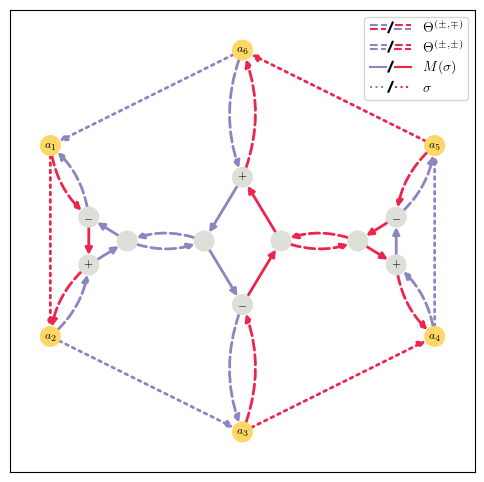

In [ ]:
x = pattern_to_simplified_graph_group[
    (
        (0, 1, 0),
        (1, 0, 1),
        (0, 0, 1, 1),
    )
][0]
render(x)
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot()
visualize_deterministic(x, ax, initial_loop)
plt.show()